# Svm

In [2]:
import numpy as np
import sklearn.utils.extmath as sm
from numpy.linalg import inv
from numpy.linalg import eig
from numpy import dot, diag
from scipy.linalg import sqrtm
from scipy.spatial.distance import euclidean
import pandas as pd
import random, math
np.random.seed(42)
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pickle


# Cluster kernel

## K Matrix Paper

In [3]:
def fill_diag(M, a):
    """
    M: square matrix
    a: array of length number of rows
    ----
    fill the diagonal of M with values of array a
    """
    s = M.shape
    D = np.zeros(s)
    for i in range(s[0]):
        D[i,i] = a[i]
    return D

def rbf_kernel(X, sigma=1):
    K = np.zeros((len(X), len(X)))
    for a in range(len(X)):
        for b in range(len(X)):
            K[a, b] = rbf_function(X[a], X[b],sigma)
    return K
            
def rbf_function(x, y, sigma=1):
    exponent = - (euclidean(x, y) ** 2) / (2 * (sigma ** 2))
    return np.exp(exponent)


def diagonal_row_sum_matrix(M):
    rows_sum = M.sum(axis = 1)
    return fill_diag(M,rows_sum)

def computeL(D,K):
    Dinv = inv(D)
    return sqrtm(Dinv).dot(K).dot(sqrtm(Dinv))

def build_K(lambdaCut, transfer, X, sigma=0.5):
    
    #Step 1 - K matrix
    K = rbf_kernel(X, sigma)
    D = diagonal_row_sum_matrix(K)
    
    #Step 2 - L matrix
    L = computeL(D, K)
    eigen_vals, U = eig(L)
    Q = diag(eigen_vals)
    
    #Step 3 - Transfer Function
    #choosing lambdacut
    lambdaCut=1
    newEigen = transfer(eigen_vals, lambdaCut)
    newEigen = diag(newEigen)
    
    #Step 4 - New Kernel matrix
    newL = U.dot(newEigen).dot(U.T)
    newD = inv(diag(diag(L)))
    newK = sqrtm(newD).dot(newL).dot(sqrtm(newD))
    return newK
    

#TRANSFER FUNCTION
def linear(vals, lambdaCut):
    return vals

def step(vals,lambdaCut):
    return [ 1 if x >= lambdaCut else 0 for x in vals ]

def linear_step(vals, lambdaCut):
    return [ x if x >= lambdaCut else 0 for x in vals ]

def polynomial(vals, exponent):
    return [ np.power(x, exponent) for x in vals ]

def polystep(vals, lambdaCut):
    return [ np.power(x, 2) if x > lambdaCut else np.sqrt(x) for x in vals ]
    
    

In [4]:
#dummy example
nb_samples = 2 #nb of samples
dim_sample = 2
X = np.random.rand(nb_samples,dim_sample)
lambdaCut = 1
K = build_K(lambdaCut, linear, X)
print(K)

[[1.         0.60445196]
 [0.60445196 1.        ]]


In [5]:
K = build_K(lambdaCut, linear, X, sigma=39)
print(K)

[[1.         0.99991726]
 [0.99991726 1.        ]]


## Linear Classifier  - SVM functions


In [6]:
### Kernels
#Defining a linear Kernel
def kernel_1(li1, li2):
    #assuming that li1 and li2 are numpy arrays
    scalar_product = np.sum(li1 * li2)
    return scalar_product

#defining a polynomial kernel with degree p
def kernel_2(li1, li2, p):
    scalar_product=np.sum(li1 * li2)
    value = math.pow((scalar_product + 1), p)
    return value

#distance function for Gaussian Kernel
def dist(l1,l2):
    li3 = l1 - l2
    li3 = li3 * li3
    dist_sq = np.sum(li3)
    return dist_sq


#defining a gaussian kernel with parameter gamma
def kernel_3(li1, li2, gamma):
    Distance_sq = dist(li1, li2)
    temp = gamma * Distance_sq
    value = math.exp( - temp)
    return value

def choose_kernel(num, li1, li2, deg = 0, gamma = 0):
    if(num == 1):
        return kernel_1(li1, li2)
    elif(num == 2):
        return kernel_2(li1, li2, deg)
    else:
        return kernel_3(li1, li2, gamma)
    
### SVM inherent functions
# Global matrix - needs to be as a global variable
def pre_cal(features_list, target_list, kernel, deg, gamma):
    
    P_matrix = []
    
    for i in range(len(target_list)):
        tmp_li = []
        for j in range(len(target_list)):
            tmp_li.append(target_list[i] * target_list[j] * choose_kernel(kernel, features_list[i], features_list[j], deg, gamma))
        tmp_li = np.array(tmp_li)
        P_matrix.append(tmp_li) #p matrix has been created

    return P_matrix

# Constraint functions
def zerofun(alpha_list):
    return np.dot(alpha_list, target_list) #this is the value which should be constrained to zero

# Objective Function
def objective(alpha_list):
    
    sum1=0
    sum2=0    
    for i in range(len(alpha_list)):
        sum1 += alpha_list[i]
        sum2 += alpha_list[i] * np.dot(alpha_list,P_mat[i]) #here alpha list is assumed to be numpy array

    sum2 = sum2 / 2

    return (sum2 - sum1)

# Indicator Function
def indicator(new_data, features_list, target_list, kernel, alpha_list, b, deg, gamma):
    somme = 0
    #print(alpha_list)
    for i in range(len(alpha_list)):
        if(alpha_list[i] != 0):
            somme += alpha_list[i] * target_list[i] * choose_kernel(kernel, new_data, features_list[i], deg, gamma)
        else:
            continue

    ind = (somme - b)

    return ind


#Return B
def get_b(alphas, non_zeros_indices, inputs, targets, kernel, p_or_sigma = 0):
    b=[]
    bb = 0
    
    for i in non_zeros_indices:
        bb = 0
        for j in range(0, len(inputs)):
            bb += alphas[j] * targets[j] * kernel(inputs[i], inputs[j], p_or_sigma)
        bb -= targets[i]
        b.append(bb)  
    
    return np.mean(b)



# Plot
def plot(ClassA, ClassB, filtered_alphas, b, kernel, slack, deg, gamma):

    plt.plot([p[0] for p in ClassA],[p[1] for p in ClassA],'b.')
    plt.plot([p[0] for p in ClassB],[p[1] for p in ClassB],'r.')
    plt.axis('equal')

    xgrid = np.linspace(-5,5)  #by default it is 50 in numpy
    ygrid = np.linspace(-4,4)  


    grid = np.array([[indicator(np.array([x,y]), features_list, target_list, kernel, filtered_alphas,b, deg, gamma) for x in xgrid]for y in ygrid])
    #print(grid)
    plt.contour(xgrid,ygrid,grid,(-1,0,1),colors=('red','black','blue'),linewidths=(1,3,1))
    plt.xlabel("Feature1")
    plt.ylabel("Feature2")
    plt.title("Decision Boundary with Margins with C value : "+str(slack))
    #plt.savefig("part4_rbf_1_C_"+str(slack)+".png")
    plt.show()

In [7]:
def train(features_list, target_list, kernel, slack, deg = 0, gamma = 0):
    
    N = len(features_list)
    non_zero_indices = []
    
    # Minimising Function
    ret = minimize(objective,np.zeros(N),bounds=[(0,slack) for b in range(features_list.shape[0])],constraints={'type':'eq','fun':zerofun})
    alphas = ret['x']
    
    # Retreive Non zero alphas
    filtered_alphas = []
    for i in range(len(alphas)):
        #if the alpha is less 10-5 then i will consider it as 0 === TRESHOLD
        if(alphas[i]<math.pow(10,-5)):
            filtered_alphas.append(0)
        else:
            if alphas[i] <= slack:
                non_zero_indices.append(i)
            support_vec=features_list[i]
            support_target=target_list[i]
            filtered_alphas.append(alphas[i])
            
    # Return b's
    b = get_b(filtered_alphas, non_zero_indices, features_list, target_list, kernel, deg)
    
    
    return filtered_alphas, b, non_zero_indices 

def test_score_svm(test_features, test_targets, train_features, train_targets, kernel, alpha_list, b, deg = 0, gamma = 0 ):
    
    predictions = []
    for instance in range(0, len(test_features)):
        prediction = indicator(test_features[instance], train_features, train_targets, kernel, alpha_list, b, deg, gamma)
        predictions.append(prediction)
    
    temp = []
    for prediction in predictions:
        if prediction > 0:
            temp.append(1)
        else:
            temp.append(-1)
    predictions = temp
    
    true = np.array(test_targets)
    preds = np.array(predictions)
    error = np.sum(test_targets != predictions)
    
    return predictions, error

## Logistic Regression

In [8]:
def logistic_function(output):
    return 1 / ( 1 + np.exp( - output ) )

def update_coefficient(curr_coefficient, prediction, feature, target, learning_rate):
    new_coeff = curr_coefficient + ( learning_rate * ( target - prediction ) * prediction * ( 1 - prediction ) * feature )
    return new_coeff

def update_coefficients(coefficients, b0, prediction, instance, target, learning_rate):
    new_coeffs = []
    for coefficient in range(len(coefficients)):
        new_coeff = update_coefficient(coefficients[coefficient], prediction, instance[coefficient], target, learning_rate)
        new_coeffs.append(new_coeff)
    newB = update_coefficient(b0, prediction, 1, target, learning_rate)
    return new_coeffs, newB

def prediction(x, coefficients, b0):
    output = np.sum( np.array(coefficients) * np.array(x) ) + b0
    prediction = logistic_function(output)
    
    return prediction
    


def epoch_logistic_regression(inputs, targets, coefficients, b0):
    predictions = []
    for instance in range(len(inputs)):
        output = np.sum( np.array(coefficients) * np.array(inputs[instance]) ) + b0
        prediction = logistic_function(output)
        coefficients, b0 = update_coefficients(coefficients, b0, prediction, inputs[instance], targets[instance], 0.3)
        predictions.append(prediction)
        
    predictions = [0 if x < 0.5 else 1 for x in predictions]
    
    accuracy = (np.sum(np.array(predictions) == np.array(targets))) / len(targets)

    return coefficients, b0, accuracy

def logistic_regression(inputs, targets):
    coefficients = np.zeros(len(inputs[0]))
    b0 = 0
    
    old_accuracy = 0
    curr_accuracy = 50
    diff = 50
    
    i = 0
    
    while(diff > 0):
        coefficients, b0, curr_accuracy = epoch_logistic_regression(inputs, targets, coefficients, b0)
        diff = curr_accuracy - old_accuracy
        diff = np.abs(diff)
        
        old_accuracy = curr_accuracy
        i+=1
        
    return coefficients, b0, old_accuracy

def test_logistic(inputs, targets, coefficients, b0):
    
    predictions = []
    
    for i in range(0, len(inputs)):
        pred = prediction(inputs[i], coefficients, b0)
        predictions.append(pred)
        
    predictions = [0 if x < 0.5 else 1 for x in predictions]
    error = (np.sum(np.array(predictions) != np.array(targets))) 
    return error
        
        
    
    
        
        

# Digit dataset

In [9]:
import pickle
from numpy.core import multiarray
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [10]:
with open("../Dataset/digitDataset.pickle", "rb") as fp:
    digits = pickle.load(fp,encoding='bytes')
    
# SVM compatible outputs
for i in range(0, len(digits)):
    if digits[i][1] == 0:
        digits[i][1] = -1.
    else:
        digits[i][1] = 1.
        
# Permutations to shuffle the dataset
permute=list(range(len(digits)))
random.shuffle(permute)
digits = np.array(digits)
digits = digits[permute, :]

# Separate Targets from features
Xs = []
labels = []
for i in range(0, len(digits)):
    Xs.append(digits[i][0])
    labels.append(digits[i][1])

In [11]:
scaler = StandardScaler()
new_Xs = scaler.fit_transform(Xs)
Xs = new_Xs

## Independent main functions

In [11]:
n_labeled = 40
kernel_k = polystep
features = Xs
labels = labels
slack = 10
size_test = 2000 - n_labeled

'''
n_labeled : Number of labeled instances
kernel_k : Which kernel to use for the K_matrix in the paper
                - linear
                - step
                - linear step
                - polynomial
features : original feature data
kernel_svm : Which kernel to use in the svm
                - 1: linear
                - 2: polynomial
                - 3: rbf
slack : slack value in the svm

'''

# Building k_matrix
lambdaCut = n_labeled + 10;
k_matrix = build_K(lambdaCut, kernel_k, features, sigma = 0.55) 

# Subset the data (50-fold cross validation)
X_k = {}
labels_k = {}
j = -1
for i in range(0, len(digits)):

    if i%40 == 0:
        if i != 0:
            X_k[j] = np.array(X_k[j])
            labels_k[j] = np.array(labels_k[j])
        j += 1
        X_k[j] = []
        labels_k[j] = []

    X_k[j].append(k_matrix[i])
    labels_k[j].append(labels[i])
    
X_k[j] = np.array(X_k[j])
labels_k[j] = np.array(labels_k[j])
    
total_error = {}

In [12]:
kernel_svm_no = 2
kernel_svm = kernel_2
degree = 2
gamma = 5
for fold in X_k:
    total_error[fold] = 0

    # pre_cal(features_list, target_list, kernel, deg, gamma)
    target_list = labels_k[fold]

    P_mat = pre_cal(X_k[fold], target_list, kernel_svm_no, degree, gamma)

    # train(features_list, target_list, kernel, slack, degree, gamma)
    alpha, b, sv_indices = train(X_k[fold], target_list, kernel_svm, slack, degree, gamma)

    for test_fold in X_k:
        if test_fold != fold:
            # test_score_svm(test_features, test_targets, train_features, train_targets, kernel, alpha_list, b, deg=0, gamma=0 )
            targets_list = labels_k[test_fold]
            test_predict, error = test_score_svm(X_k[test_fold], targets_list, X_k[fold], labels_k[fold], kernel_svm_no, alpha, b, degree, gamma )
            total_error[fold] += error / size_test
    print("fold number ", fold, "has an error of ", total_error[fold])

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


fold number  0 has an error of  0.48520408163265305
fold number  1 has an error of  0.489795918367347
fold number  2 has an error of  0.4239795918367346
fold number  3 has an error of  0.4892857142857143
fold number  4 has an error of  0.4852040816326531
fold number  5 has an error of  0.42091836734693866
fold number  6 has an error of  0.485204081632653
fold number  7 has an error of  0.5061224489795918
fold number  8 has an error of  0.4867346938775509
fold number  9 has an error of  0.4709183673469387
fold number  10 has an error of  0.46530612244897956
fold number  11 has an error of  0.48265306122448975
fold number  12 has an error of  0.46326530612244887
fold number  13 has an error of  0.48622448979591837
fold number  14 has an error of  0.4831632653061224
fold number  15 has an error of  0.4749999999999999
fold number  16 has an error of  0.4377551020408162
fold number  17 has an error of  0.4153061224489797
fold number  18 has an error of  0.4607142857142857
fold number  19 ha

## Function to experiment 

### Different polystep cutoffs

In [14]:
## Fixed parameters for the cluster kernel algorithm
n_labeled = 40
kernel_k = polystep
features = Xs
labels = labels
slack = 10
size_test = 2000 - n_labeled

## Fixed parameters for the svm
kernel_svm_no = 2
kernel_svm = kernel_2
degree = 3
gamma = 5

'''
n_labeled : Number of labeled instances
kernel_k : Which kernel to use for the K_matrix in the paper
                - linear
                - step
                - linear step
                - polynomial
features : original feature data
kernel_svm : Which kernel to use in the svm
                - 1: linear
                - 2: polynomial
                - 3: rbf
slack : slack value in the svm

'''

polystep_error = {}
for lambdaCut in range(6, 21):
    total_error = {}
    print("Trying with lambdaCut : ", lambdaCut)
    # Building k_matrix
    k_matrix = build_K(lambdaCut, kernel_k, features, sigma = 5) 
    print("     Matrix built!")

    # Subset the data (50-fold cross validation)
    X_k = {}
    labels_k = {}
    j = -1
    for i in range(0, len(digits)):

        if i%40 == 0:
            if i != 0:
                X_k[j] = np.array(X_k[j])
                labels_k[j] = np.array(labels_k[j])
            j += 1
            X_k[j] = []
            labels_k[j] = []

        X_k[j].append(k_matrix[i])
        labels_k[j].append(labels[i])

    X_k[j] = np.array(X_k[j])
    labels_k[j] = np.array(labels_k[j])
    
    for fold in X_k:
        total_error[fold] = 0

        # pre_cal(features_list, target_list, kernel, deg, gamma)
        target_list = labels_k[fold]

        P_mat = pre_cal(X_k[fold], target_list, kernel_svm_no, degree, gamma)

        # train(features_list, target_list, kernel, slack, degree, gamma)
        alpha, b, sv_indices = train(X_k[fold], target_list, kernel_svm, slack, degree, gamma)

        for test_fold in X_k:
            if test_fold != fold:
                # test_score_svm(test_features, test_targets, train_features, train_targets, kernel, alpha_list, b, deg=0, gamma=0 )
                targets_list = labels_k[test_fold]
                test_predict, error = test_score_svm(X_k[test_fold], targets_list, X_k[fold], labels_k[fold], kernel_svm_no, alpha, b, degree, gamma )
                total_error[fold] += error / size_test
    curr_error = list(total_error.values())
    print("Mean Test Error ", np.mean(curr_error))
    polystep_error[lambdaCut] = curr_error
    with open("./polystep_errors.pickle", "wb") as fp:
        pickle.dump(polystep_error, fp)
        fp.close()

    

Trying with lambdaCut :  6
     Matrix built!
Mean Test Error  0.49539795918367346
Trying with lambdaCut :  7


KeyboardInterrupt: 

###  Normal Svm

#### Own SVM implementation

In [51]:
# Subset the data (50-fold cross validation)
X_svm = {}
labels_svm = {}
j = -1
for i in range(0, len(digits)):

    if i%40 == 0:
        if i != 0:
            X_svm[j] = np.array(X_svm[j])
            labels_svm[j] = np.array(labels_svm[j])
        j += 1
        X_svm[j] = []
        labels_svm[j] = []

    X_svm[j].append(Xs[i])
    labels_svm[j].append(labels[i])

X_svm[j] = np.array(X_svm[j])
labels_svm[j] = np.array(labels_svm[j])

total_error = {}
for fold in X_svm:
    total_error[fold] = 0

    # pre_cal(features_list, target_list, kernel, deg, gamma)
    target_list = labels_svm[fold]

    P_mat = pre_cal(X_svm[fold], target_list, kernel_svm_no, degree, gamma)

    # train(features_list, target_list, kernel, slack, degree, gamma)
    alpha, b, sv_indices = train(X_svm[fold], target_list, kernel_svm, slack, degree, gamma)

    for test_fold in X_k:
        if test_fold != fold:
            # test_score_svm(test_features, test_targets, train_features, train_targets, kernel, alpha_list, b, deg=0, gamma=0 )
            targets_list = labels_svm[test_fold]
            test_predict, error = test_score_svm(X_svm[test_fold], targets_list, X_svm[fold], labels_svm[fold], kernel_svm_no, alpha, b, degree, gamma )
#             print(test_predict)
            total_error[fold] += error / size_test
#             print(error)
    print("Mean Test Error ", total_error[fold])
    with open("./svm_errors.pickle", "wb") as fp:
        pickle.dump(total_error, fp)
        fp.close()

Mean Test Error  0.3280612244897959
Mean Test Error  0.36683673469387756
Mean Test Error  0.3520408163265306
Mean Test Error  0.41938775510204074
Mean Test Error  0.34795918367346945
Mean Test Error  0.3617346938775509
Mean Test Error  0.28010204081632656
Mean Test Error  0.36224489795918363
Mean Test Error  0.36989795918367346
Mean Test Error  0.42755102040816323
Mean Test Error  0.3887755102040816
Mean Test Error  0.3423469387755103
Mean Test Error  0.3663265306122449
Mean Test Error  0.3489795918367348
Mean Test Error  0.4081632653061222
Mean Test Error  0.40102040816326523
Mean Test Error  0.44693877551020406
Mean Test Error  0.41785714285714287
Mean Test Error  0.3239795918367347
Mean Test Error  0.44336734693877555
Mean Test Error  0.32397959183673475
Mean Test Error  0.44285714285714284
Mean Test Error  0.3489795918367347
Mean Test Error  0.32091836734693874
Mean Test Error  0.37193877551020404
Mean Test Error  0.5219387755102042
Mean Test Error  0.3316326530612244
Mean Test Err

In [12]:
len(Xs[0])

256

#### Scikit SVM

In [1]:
from sklearn import svm
import pickle
import random
import math

# Load dataset
with open("../Dataset/digitDataset.pickle", "rb") as fp:
	digits = pickle.load(fp,encoding='bytes')
# list of testerror for every run
acclist = []

# compute 100 tuns
for z in range(0,100):
    # tale 8 samples from class 1 and 2 for fitting process
    trainSamples = []
    trainSamples += random.sample(digits[0:1000],8)
    trainSamples += random.sample(digits[1001:],8)
    trainX = []
    trainY = []
    for x in trainSamples:
        trainX.append(x[0])
        trainY.append(x[1])
    clf = svm.SVC(gamma='scale')
    clf.fit(trainX,trainY)

    # calulate testerror
    corrects = 0.0
    count = 0.0
    for x in digits:
        pred = clf.predict(x[0].reshape(1,-1))
        count+=1.0
        if(pred == x[1]):
            corrects += 1.0
    acclist.append((count-corrects)/count)
print("mean: ")
mean = sum(acclist)/100.0
print(mean)
print("standard deviation: ")
der = 0
sq = []
for x in acclist:
    sq.append((x-mean)**2)
sqmean = sum(sq)/100.0
print(math.sqrt(sqmean))


mean: 
0.33877
standard deviation: 
0.05666054270830804


### Different cutoffs with logistic regression


In [17]:
with open("../Dataset/digitDataset.pickle", "rb") as fp:
    digits = pickle.load(fp,encoding='bytes')
    
# SVM compatible outputs
for i in range(0, len(digits)):
    if digits[i][1] == 0:
        digits[i][1] = 0.
    else:
        digits[i][1] = 1.
        
# Permutations to shuffle the dataset
permute=list(range(len(digits)))
random.shuffle(permute)
digits = np.array(digits)
digits = digits[permute, :]

# Separate Targets from features
Xs = []
labels = []
for i in range(0, len(digits)):
    Xs.append(digits[i][0])
    labels.append(digits[i][1])

In [18]:
scaler = StandardScaler()
new_Xs = scaler.fit_transform(Xs)
Xs = new_Xs

In [20]:
## Fixed parameters for the cluster kernel algorithm
n_labeled = 40
kernel_k = polystep
features = Xs
labels = labels
slack = 10
size_test = 2000 - n_labeled

## Fixed parameters for the svm
kernel_svm_no = 2
kernel_svm = kernel_2
degree = 3
gamma = 5

'''
n_labeled : Number of labeled instances
kernel_k : Which kernel to use for the K_matrix in the paper
                - linear
                - step
                - linear step
                - polynomial
features : original feature data
kernel_svm : Which kernel to use in the svm
                - 1: linear
                - 2: polynomial
                - 3: rbf
slack : slack value in the svm

'''

polystep_error = {}
cuts = list(range(6, 21))
cuts.append(40)
cuts.append(50)
for lambdaCut in cuts:
    total_error = {}
    print("Trying with lambdaCut : ", lambdaCut)
    # Building k_matrix
    k_matrix = build_K(lambdaCut, kernel_k, features, sigma = 5) 
    print("     Matrix built!")

    # Subset the data (50-fold cross validation)
    X_k = {}
    labels_k = {}
    j = -1
    for i in range(0, len(digits)):

        if i%40 == 0:
            if i != 0:
                X_k[j] = np.array(X_k[j])
                labels_k[j] = np.array(labels_k[j])
            j += 1
            X_k[j] = []
            labels_k[j] = []

        X_k[j].append(k_matrix[i])
        labels_k[j].append(labels[i])

    X_k[j] = np.array(X_k[j])
    labels_k[j] = np.array(labels_k[j])
    
    for fold in X_k:
        total_error[fold] = 0

        # pre_cal(features_list, target_list, kernel, deg, gamma)
        target_list = labels_k[fold]
        coefficients, b0, accuracy = logistic_regression(X_k[fold], target_list)
#         print(target_list)
#         print(coefficients[0])
        
        for test_fold in X_k:
            if test_fold != fold:
                # test_score_svm(test_features, test_targets, train_features, train_targets, kernel, alpha_list, b, deg=0, gamma=0 )
                targets_list = labels_k[test_fold]
                error = test_logistic(X_k[test_fold], targets_list, coefficients, b0)
                total_error[fold] += error / size_test
    curr_error = list(total_error.values())
    print("Mean Test Error ", np.mean(curr_error))
    polystep_error[lambdaCut] = curr_error
    with open("./polystep_errors_logistic.pickle", "wb") as fp:
        pickle.dump(polystep_error, fp)
        fp.close()

    

Trying with lambdaCut :  6
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  7
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  8
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  9
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  10
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  11
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  12
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  13
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  14
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  15
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  16
     Matrix built!
Mean Test Error  0.42067346938775513
Trying with lambdaCut :  17
     Matrix built!
Mean Test Error  0.42067346938775

### Different parameters for the svm

#### Polynomial

In [13]:
## Fixed parameters for the cluster kernel algorithm
n_labeled = 40
kernel_k = polystep
features = Xs
labels = labels
slack = 10
lambdaCut = 10
size_test = 2000 - n_labeled

## Fixed parameters for the svm
kernel_svm_no = 2
kernel_svm = kernel_2
degree = [2,3,4,5,6,7]
gamma = 0
# gamma = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

'''
n_labeled : Number of labeled instances
kernel_k : Which kernel to use for the K_matrix in the paper
                - linear
                - step
                - linear step
                - polynomial
features : original feature data
kernel_svm : Which kernel to use in the svm
                - 1: linear
                - 2: polynomial
                - 3: rbf
slack : slack value in the svm

'''



# Building k_matrix
k_matrix = build_K(lambdaCut, kernel_k, features, sigma = 5) 
print("     Matrix built!")

# Subset the data (50-fold cross validation)
X_k = {}
labels_k = {}
j = -1
for i in range(0, len(digits)):

    if i%40 == 0:
        if i != 0:
            X_k[j] = np.array(X_k[j])
            labels_k[j] = np.array(labels_k[j])
        j += 1
        X_k[j] = []
        labels_k[j] = []

    X_k[j].append(k_matrix[i])
    labels_k[j].append(labels[i])

X_k[j] = np.array(X_k[j])
labels_k[j] = np.array(labels_k[j])

    
degree_error = {}

for deg in degree:

    total_error = {}
    
    
    for fold in X_k:
        total_error[fold] = 0

        # pre_cal(features_list, target_list, kernel, deg, gamma)
        target_list = labels_k[fold]

        P_mat = pre_cal(X_k[fold], target_list, kernel_svm_no, deg, gamma)

        # train(features_list, target_list, kernel, slack, degree, gamma)
        alpha, b, sv_indices = train(X_k[fold], target_list, kernel_svm, slack, deg, gamma)

        for test_fold in X_k:
            if test_fold != fold:
                targets_list = labels_k[test_fold]
                test_predict, error = test_score_svm(X_k[test_fold], targets_list, X_k[fold], labels_k[fold], kernel_svm_no, alpha, b, deg, gamma )
                total_error[fold] += error / size_test
    curr_error = list(total_error.values())
    print("Mean Test Error ", np.mean(curr_error))
    degree_error[deg] = curr_error
    with open("./degree_svm_hpm_errors.pickle", "wb") as fp:
        pickle.dump(degree_error, fp)
        fp.close()

    

     Matrix built!


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


Mean Test Error  0.3979897959183674
Mean Test Error  0.4141836734693877


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Test Error  0.46521428571428575
Mean Test Error  0.4774183673469388
Mean Test Error  0.4868163265306123
Mean Test Error  0.49506122448979595


In [14]:
degree_error

{2: [0.43673469387755093,
  0.42346938775510207,
  0.37500000000000006,
  0.4489795918367348,
  0.46734693877551015,
  0.3852040816326531,
  0.363265306122449,
  0.367857142857143,
  0.33826530612244904,
  0.43112244897959173,
  0.37295918367346936,
  0.3709183673469388,
  0.36530612244897964,
  0.473469387755102,
  0.37091836734693884,
  0.376530612244898,
  0.3433673469387756,
  0.34030612244897956,
  0.423469387755102,
  0.488265306122449,
  0.35867346938775524,
  0.376530612244898,
  0.3698979591836736,
  0.37500000000000017,
  0.36530612244897953,
  0.413265306122449,
  0.42244897959183675,
  0.4954081632653062,
  0.3749999999999999,
  0.4076530612244897,
  0.37908163265306133,
  0.3637755102040816,
  0.388265306122449,
  0.46683673469387754,
  0.42551020408163254,
  0.3653061224489796,
  0.35000000000000003,
  0.38673469387755094,
  0.35663265306122455,
  0.44030612244897954,
  0.46887755102040807,
  0.4795918367346939,
  0.3362244897959183,
  0.34030612244897956,
  0.37346938775

#### Gamma

In [15]:
## Fixed parameters for the cluster kernel algorithm
n_labeled = 40
kernel_k = polystep
features = Xs
labels = labels
slack = 10
lambdaCut = 10
size_test = 2000 - n_labeled

## Fixed parameters for the svm
kernel_svm_no = 3
kernel_svm = kernel_3
# degree = [2,3,4,5,6,7]
# gammas = 0
deg = 0
gammas = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 15, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100]

'''
n_labeled : Number of labeled instances
kernel_k : Which kernel to use for the K_matrix in the paper
                - linear
                - step
                - linear step
                - polynomial
features : original feature data
kernel_svm : Which kernel to use in the svm
                - 1: linear
                - 2: polynomial
                - 3: rbf
slack : slack value in the svm

'''



# Building k_matrix
k_matrix = build_K(lambdaCut, kernel_k, features, sigma = 5) 
print("     Matrix built!")

# Subset the data (50-fold cross validation)
X_k = {}
labels_k = {}
j = -1
for i in range(0, len(digits)):

    if i%40 == 0:
        if i != 0:
            X_k[j] = np.array(X_k[j])
            labels_k[j] = np.array(labels_k[j])
        j += 1
        X_k[j] = []
        labels_k[j] = []

    X_k[j].append(k_matrix[i])
    labels_k[j].append(labels[i])

X_k[j] = np.array(X_k[j])
labels_k[j] = np.array(labels_k[j])

    
gamma_error = {}

for gamma in gammas:

    total_error = {}
    
    
    for fold in X_k:
        total_error[fold] = 0

        # pre_cal(features_list, target_list, kernel, deg, gamma)
        target_list = labels_k[fold]

        P_mat = pre_cal(X_k[fold], target_list, kernel_svm_no, deg, gamma)

        # train(features_list, target_list, kernel, slack, degree, gamma)
        alpha, b, sv_indices = train(X_k[fold], target_list, kernel_svm, slack, deg, gamma)

        for test_fold in X_k:
            if test_fold != fold:
                targets_list = labels_k[test_fold]
                test_predict, error = test_score_svm(X_k[test_fold], targets_list, X_k[fold], labels_k[fold], kernel_svm_no, alpha, b, deg, gamma )
                total_error[fold] += error / size_test
    curr_error = list(total_error.values())
    print("Mean Test Error ", np.mean(curr_error))
    gamma_error[gamma] = curr_error
    with open("./gamma_svm_hpm_errors.pickle", "wb") as fp:
        pickle.dump(gamma_error, fp)
        fp.close()

    

     Matrix built!


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


Mean Test Error  0.41311224489795917
Mean Test Error  0.4016428571428572
Mean Test Error  0.4055408163265306
Mean Test Error  0.4097244897959184
Mean Test Error  0.4130408163265306
Mean Test Error  0.42976530612244884
Mean Test Error  0.4610918367346939
Mean Test Error  0.47923469387755097
Mean Test Error  0.48115306122448975
Mean Test Error  0.4813775510204081
Mean Test Error  0.48119387755102033
Mean Test Error  0.48095918367346935
Mean Test Error  0.4810918367346938
Mean Test Error  0.4834999999999999
Mean Test Error  0.4854489795918367
Mean Test Error  0.5001326530612245
Mean Test Error  0.5015918367346938
Mean Test Error  0.5017755102040815
Mean Test Error  0.501469387755102
Mean Test Error  0.5015408163265306
Mean Test Error  0.5010510204081632
Mean Test Error  0.5011428571428571
Mean Test Error  0.5017653061224489
Mean Test Error  0.5020204081632653
Mean Test Error  0.5014489795918368
Mean Test Error  0.5016326530612244
Mean Test Error  0.5019285714285714
Mean Test Error  0.5022

### Different distributions in the training

In this part, we extend the research by trying out several imbalance levels :
0, 10, 30, 50, 70, 90, 100
with the same methodology (40 training instances and the rest as a test)

In [12]:
# Build K matrix
kernel_k = polystep
slack = 10
lambdaCut = 50
k_matrix = build_K(lambdaCut, kernel_k, Xs, sigma = 5) 

# Separate the classes
Xs0 = []
Xs1 = []
for instance in range(0, len(Xs)):
    if labels[instance] == -1:
        Xs0.append(k_matrix[instance])
    elif labels[instance] == 1:
        Xs1.append(k_matrix[instance])

labels0 = - 1. * np.ones(len(Xs0))
labels1 = np.ones(len(Xs1))

In [16]:
import random
# Select the instances
def select_percentage(Xs0, Xs1, percentage_1, seed):
    random.seed(seed)
    x0 = Xs0.copy()
    x1 = Xs1.copy()
    
    length = len(Xs0) + len(Xs1)
    n_instances1 = int((40 / 100) * percentage_1)
    n_instances0 = 40 - n_instances1
    
    trainingX = []
    trainingY = []    
    
    for i in range((n_instances1)):
        random_index = random.randint(0, len(x1) - 1)
        instance = x1.pop(random_index)
        trainingX.append(instance)
        trainingY.append(1)
        
    for i in range((n_instances0)):
        random_index = random.randint(0, len(x0) - 1)
        instance = x0.pop(random_index)
        trainingX.append(instance)
        trainingY.append(-1)
        
    y_test0 = list(-1 * np.ones(len(x0)))
    y_test1 = list(np.ones(len(x1)))
    
    test_x = x0 + x1
    test_y = y_test0 + y_test1
    return np.array(trainingX), np.array(trainingY), np.array(test_x), np.array(test_y)        
    

In [17]:
## Fixed parameters for the cluster kernel algorithm
n_labeled = 40
kernel_k = polystep
slack = 10
lambdaCut = 50
size_test = 2000 - n_labeled

## Fixed parameters for the svm
kernel_svm_no = 2
kernel_svm = kernel_2
deg = 2
gamma = 0

percentages = list(range(0, 100))

total_error = {}

for percentage in percentages:
    total_error[percentage] = []

    for i in range(0, 50):
        
        # Get training and testing
        seed = random.randint(0, 9999999)
        training_x, training_y, test_x, test_y = select_percentage(Xs0, Xs1, percentage, seed)
        
        # Training
        target_list = training_y        
        P_mat = pre_cal(training_x, target_list, kernel_svm_no, deg, gamma)        
        alpha, b, sv_indices = train(training_x, target_list, kernel_svm, slack, deg, gamma)
        
        # Testing
        targets_list = test_y
        test_predict, error = test_score_svm(test_x, targets_list, training_x, training_y, kernel_svm_no, alpha, b, deg, gamma )
        total_error[percentage].append(error / size_test)
        
    print("Mean Test Error for percentage ", percentage, np.mean(total_error[percentage]))
    
    with open("./different_distributions.pickle", "wb") as fp:
        pickle.dump(total_error, fp)
        fp.close()
        
        
       

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Test Error for percentage  0 0.5102040816326531
Mean Test Error for percentage  1 0.5102040816326531
Mean Test Error for percentage  2 0.5102040816326531
Mean Test Error for percentage  3 0.5096836734693876
Mean Test Error for percentage  4 0.5096938775510202
Mean Test Error for percentage  5 0.5091734693877552
Mean Test Error for percentage  6 0.5091836734693878
Mean Test Error for percentage  7 0.5091428571428572
Mean Test Error for percentage  8 0.508622448979592
Mean Test Error for percentage  9 0.5086428571428573
Mean Test Error for percentage  10 0.5080918367346939
Mean Test Error for percentage  11 0.5080816326530614
Mean Test Error for percentage  12 0.5080714285714286
Mean Test Error for percentage  13 0.507591836734694
Mean Test Error for percentage  14 0.507561224489796
Mean Test Error for percentage  15 0.5070510204081632
Mean Test Error for percentage  16 0.5070102040816326
Mean Test Error for percentage  17 0.507030612244898
Mean Test Error for percentage  18 0.50637

# Text dataset

In [15]:
import pickle
from numpy.core import multiarray
import pandas as pd
from scipy.spatial.distance import minkowski

In [16]:
with open("../Dataset/textDataset.pickle", "rb") as fp:
    text = pickle.load(fp, encoding="latin-1")

In [17]:
# SVM compatible outputs
for i in range(0, len(text)):
    if text[i][1] == 0:
        text[i][1] = -1.
    else:
        text[i][1] = 1.


# Separate Targets from features
Xs = []
labels = []
print("textdataset size before filtering ",len(text))
for i in range(0, len(text)):
    #THRESHOLD => Check if the dimensionality of the data is inf to 360 to filter out some words.
    if(len(text[i][0].data) < 360):
        Xs.append(text[i][0].data)
        labels.append(text[i][1])

textdataset size before filtering  1951


In [18]:
print("new textDatasetsize ",len(Xs))

new textDatasetsize  1919


In [19]:
#extend NDARRAYS length
def extend(list_to_extend, target_len):
    '''
    a = np.ndarray((2,), buffer=np.array([1,2,3])
    >>> array([2, 3])
    extend(a, 5)
    >>> array([2, 3, 0, 0, 0])
    '''
    return np.append(list_to_extend,np.zeros((target_len-len(list_to_extend),)))

def max_len_of_lists(lists):
    maxLen = len(lists[0])
    for i in range(1, len(lists)):
        listLen = len(lists[i])
        if listLen > maxLen:
            maxLen = listLen
    return maxLen

In [20]:
#extending the arrays
maxLen = max_len_of_lists(Xs)
for i in range(0, len(labels)):
    Xs[i] = extend(Xs[i],maxLen)

In [36]:
#svm parameters
n_labeled = 987
size_test = 128

In [31]:
'''
features : filtered data from the text dataset
kernel_k : Which kernel to use for the K_matrix in the paper
                - linear
                - step
                - linear step
                - polynomial
'''

# Building k_matrix
features = Xs
kernel_k = polynomial
lambdaCut = 5
k_matrix = build_K(lambdaCut, kernel_k, features, sigma = 0.55) 

In [37]:
'''
divide the the k_matrix in subsets:
    - first => X_k[0] : 987 points used for training.
    - second, third ...etc: partitions of size 'size_test' used for testing.
'''

#first partition: to change size => change the value of n_labeled
X_k = {}
labels_k = {}

X_k[0] = []
labels_k[0] = []
for i in range(0, n_labeled):
    X_k[0].append(k_matrix[i])
    labels_k[0].append(labels[i])
X_k[0] = np.array(X_k[0])
labels_k[0] = np.array(labels_k[0])


#other partitions: to change size => change the value of size_test
partition_size = size_test
begin = n_labeled
end = len(Xs)-1
partitions = 100

for part_index in range(1, partitions):
    X_k[part_index] = []
    labels_k[part_index] = []
    for i in range(0, partition_size):
        #select random data
        data_index = random.randint(begin, end)
        
        X_k[part_index].append(k_matrix[data_index])
        labels_k[part_index].append(labels[data_index])
        
    X_k[part_index] = np.array(X_k[part_index])
    labels_k[part_index] = np.array(labels_k[part_index])

In [38]:
#info about X_k
print("size of dict X_k: ",len(X_k))
for i in range(0,len(X_k)):
    print("array ",i," is of size: ",len(X_k[i]))


size of dict X_k:  100
array  0  is of size:  987
array  1  is of size:  128
array  2  is of size:  128
array  3  is of size:  128
array  4  is of size:  128
array  5  is of size:  128
array  6  is of size:  128
array  7  is of size:  128
array  8  is of size:  128
array  9  is of size:  128
array  10  is of size:  128
array  11  is of size:  128
array  12  is of size:  128
array  13  is of size:  128
array  14  is of size:  128
array  15  is of size:  128
array  16  is of size:  128
array  17  is of size:  128
array  18  is of size:  128
array  19  is of size:  128
array  20  is of size:  128
array  21  is of size:  128
array  22  is of size:  128
array  23  is of size:  128
array  24  is of size:  128
array  25  is of size:  128
array  26  is of size:  128
array  27  is of size:  128
array  28  is of size:  128
array  29  is of size:  128
array  30  is of size:  128
array  31  is of size:  128
array  32  is of size:  128
array  33  is of size:  128
array  34  is of size:  128
array  

In [34]:
'''
kernel_svm : Which kernel to use in the svm
                - 1: linear
                - 2: polynomial
                - 3: rbf
slack : slack value in the svm
n_labeled : Number of labeled instances
'''

slack = 10
kernel_svm_no = 2
kernel_svm = kernel_2
degree = 2
gamma = 1.1

#training
total_error = {}
fold = 0
print("fold: ",fold)
total_error[fold] = 0

# pre_cal(features_list, target_list, kernel, deg, gamma)
target_list = labels_k[fold]

P_mat = pre_cal(X_k[fold], target_list, kernel_svm_no, degree, gamma)
print("HERE1")

# train(features_list, target_list, kernel, slack, degree, gamma)
alpha, b, sv_indices = train(X_k[fold], target_list, kernel_svm, slack, degree, gamma)
print("HERE2")

fold:  0
HERE1
HERE2


In [39]:
#test
for test_fold in X_k:
    if test_fold != fold:
        # test_score_svm(test_features, test_targets, train_features, train_targets, kernel, alpha_list, b, deg=0, gamma=0 )
        targets_list = labels_k[test_fold]
        test_predict, error = test_score_svm(X_k[test_fold], targets_list, X_k[fold], labels_k[fold], kernel_svm_no, alpha, b, degree, gamma )
        total_error[test_fold] = error / size_test
        print("fold number ", test_fold, "has an error of ", total_error[test_fold])


print('Mean of errors: ', sum(v for k,v in total_error.items())/len(total_error))

fold number  1 has an error of  0.4140625
fold number  2 has an error of  0.46875
fold number  3 has an error of  0.5078125
fold number  4 has an error of  0.5234375
fold number  5 has an error of  0.4140625
fold number  6 has an error of  0.453125
fold number  7 has an error of  0.5
fold number  8 has an error of  0.453125
fold number  9 has an error of  0.3671875
fold number  10 has an error of  0.4609375
fold number  11 has an error of  0.5
fold number  12 has an error of  0.5078125
fold number  13 has an error of  0.3984375
fold number  14 has an error of  0.46875
fold number  15 has an error of  0.484375
fold number  16 has an error of  0.4609375
fold number  17 has an error of  0.4609375
fold number  18 has an error of  0.4453125
fold number  19 has an error of  0.4453125
fold number  20 has an error of  0.421875
fold number  21 has an error of  0.3984375
fold number  22 has an error of  0.46875
fold number  23 has an error of  0.5234375
fold number  24 has an error of  0.421875


#  This part is the random generated data - for people with trust issues

In [11]:
def create_clusters(lbA1, ubA1, lbA2, ubA2, lbB, ubB, spreadA, spreadB):
    classA = np.concatenate((np.random.randn(10,2) * spreadA + [lbA1, ubA1],
                           np.random.randn(10, 2) * spreadA + [lbA2, ubA2]))
    classB = np.random.randn(20, 2) * spreadB + [lbB, ubB]
    inputs = np.concatenate((classA, classB))
    targets = np.concatenate(
                (np.ones(classA.shape[0]),
                -np.ones(classB.shape[0])))

    N = inputs.shape[0]

    permute = list(range(N))
    random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]
    return inputs, targets, N, classA, classB

In [12]:
def generate_data():

    #generating data
    classA=np.concatenate((np.random.randn(10,2)*0.5+[1.5,0.5],np.random.randn(10,2)*0.5+[-1.5,0.5]))
    classB=np.random.randn(10,2)*0.5+[0.0,-0.5]

    inputs=np.concatenate((classA,classB))
    targets=np.concatenate((np.ones(classA.shape[0]),-np.ones(classB.shape[0])))

    N=inputs.shape[0]  #number of rows(samples)

    permute=list(range(N))
    random.shuffle(permute)

    #features_list and target_list are global variables
    inputs=inputs[permute,:]  
    targets=targets[permute]

    return (classA,classB,inputs,targets)

[[-9.25656800e-03 -6.44329319e-01]
 [ 1.22550871e-02 -2.51000854e-01]
 [-1.29353427e+00  2.18137724e-01]
 [-2.22404217e+00 -2.03731887e-01]
 [ 9.96991309e-01 -1.07094306e-01]
 [-1.50950810e+00 -1.26468232e-03]
 [ 7.25571804e-01 -2.03645870e-02]
 [ 1.61359280e-01 -9.13615472e-01]
 [ 1.07659123e+00 -8.83673781e-01]
 [ 1.84097649e+00  3.44866622e-01]
 [-1.91111020e+00  6.21843606e-01]
 [-5.43800742e-02 -2.99144139e-01]
 [-1.07117019e+00  4.20030735e-01]
 [ 1.12046241e-01 -4.93703800e-01]
 [ 1.53790228e+00  1.61419144e-01]
 [-1.34454622e+00  1.23767811e+00]
 [ 1.81205991e+00  8.14172755e-01]
 [-1.73551915e+00  6.16024969e-01]
 [-1.91274860e+00  3.39307079e-01]
 [ 3.45071996e-01 -7.00610236e-01]
 [ 1.66208318e+00  4.34928473e-01]
 [ 1.49387661e+00  5.13728143e-02]
 [ 2.59673257e-01  2.66369457e-01]
 [ 1.98755987e+00  4.26471309e-01]
 [ 1.09088966e+00  1.54619364e+00]
 [ 2.07905544e+00  8.95831347e-01]
 [ 4.88380493e-02 -8.86504892e-01]
 [-1.85922211e+00  3.93276424e-01]
 [ 1.54849798e+00  7

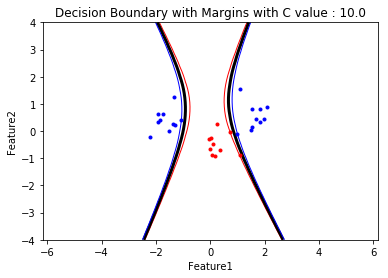

In [17]:
kernel = 2
degree = 2
gammas = 0.5

cA,cB,features_list,target_list=generate_data()  #this generates the data
N = features_list.shape[0]
x=np.linspace(10,1000,1)
for slack in x:
    
    P_mat = pre_cal(features_list, target_list, kernel, degree, gammas)  #p matrix is initialised here
    print(features_list)
    filtered_alphas, b, sv_indices = train(features_list, target_list, kernel_2, slack, degree, gammas)
    plot(cA, cB, filtered_alphas, b, kernel, slack, degree, gammas)

In [ ]:
#Jade generated data
data_list, target_list, N, cA, cB = create_clusters(random.uniform(-5,5), random.uniform(-5,5), random.uniform(-5,5), 
                                                         random.uniform(-5,5), random.uniform(-5,5), random.uniform(-5,5), random.uniform(0,1), random.uniform(0,1))
x=np.linspace(10,1000,1)
for slack in x:

    P_mat = pre_cal(data_list, target_list, kernel, deg, gamma)  #p matrix is initialised here
    filtered_alphas, b = train(data_list, target_list, kernel, slack)
    plot(cA, cB, filtered_alphas, b, kernel, slack)